# BO with AX.DEV tutorial

Overview:

1. **Gaussian Peak Function**: The `gaussian_peak` function defines a Gaussian peak centered at (0.2, 0.1) with a standard deviation of 0.1.

2. **Grid Sweep**: A grid of points from -1 to 1 is created for both `x` and `y` to evaluate the Gaussian function over a regular grid.

3. **Bayesian Optimization Setup**:
   - A Sobol sampling strategy is used for initial exploration (`num_initial_samples` points).
   - After Sobol sampling, a Bayesian optimization step is used with the `GPEI` model to optimize the objective indefinitely (`num_trials=-1`).

4. **Optimization Loop**:
   - The loop continues for up to `num_bo_samples` iterations or until a convergence criterion is met.
   - `use_gpei_ratio` controls whether exploitation (`GPEI`) or exploration (`qNIPV`) is performed in each iteration.
   - If no significant improvement is found after a specified number of iterations (`patience`), the optimization stops early.

5. **Plotting**:
   - The first subplot shows a grid evaluation of the Gaussian peak.
   - The second subplot visualizes the Bayesian optimization process by showing the points sampled and an interpolation of the sampled values.



[INFO 11-18 23:18:39] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 11-18 23:18:39] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-18 23:18:39] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter y. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-18 23:18:39] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x', parameter_type=FLOAT, range=[-1.0, 1.0]), RangeParameter(name='y', parameter_type=FLOAT, range=[-1.0, 1.0])], parameter_constraints=[]).
[INFO 11-18 23:18:39] a

Stopping early after 46 iterations due to lack of improvement.


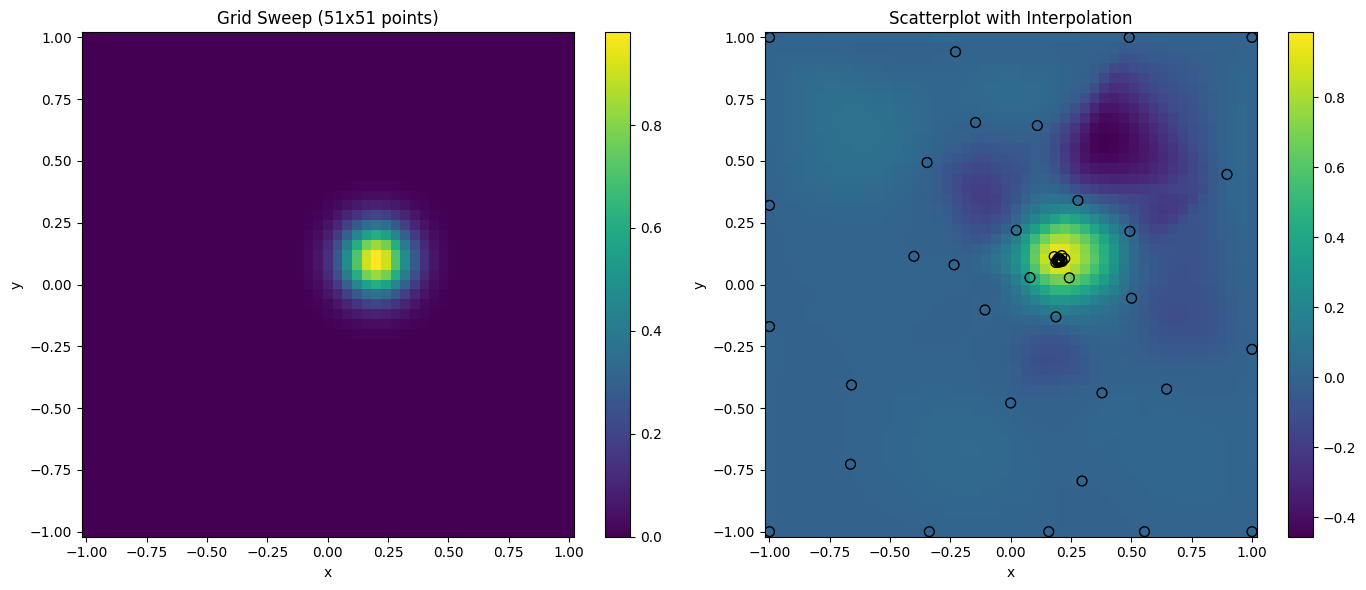

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from ax import optimize
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
import random
from typing import Tuple

# Define the Gaussian peak function.
def gaussian_peak(x: float, y: float) -> float:
    """
    Gaussian peak function to simulate an objective with a peak.

    Args:
        x (float): x-coordinate value.
        y (float): y-coordinate value.

    Returns:
        float: Value of the Gaussian peak at the given (x, y) point.
    """
    x_peak, y_peak = 0.2, 0.1
    sigma = 0.1
    return np.exp(-((x - x_peak) ** 2 + (y - y_peak) ** 2) / (2 * sigma ** 2))

# Create a grid sweep version (51 x 51 points).
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = gaussian_peak(x_grid, y_grid)

# Number of Sobol samples for initial exploration.
num_initial_samples = 5
mcp_0 = 500
use_gpei_ratio = 0.9  # Ratio to use GPEI versus qNIPV

# Setting up the Bayesian optimizer using Ax with a custom generation strategy.
generation_strategy = GenerationStrategy(
    steps=[
        GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
        GenerationStep(model=Models.GPEI, num_trials=-1),
    ]
)

ax_client = AxClient(generation_strategy=generation_strategy)
ax_client.create_experiment(
    name="2d_gaussian_peak_optimization",
    parameters=[
        {"name": "x", "type": "range", "bounds": [-1.0, 1.0]},
        {"name": "y", "type": "range", "bounds": [-1.0, 1.0]},
    ],
    objective_name="z",
    minimize=False,  # Set True if you want to minimize the objective
)

# Lists to store sampled points and their objective values.
z_samples = []
x_samples = []
y_samples = []

# Initial exploration with Sobol sampling.
for _ in range(num_initial_samples):
    params, trial_index = ax_client.get_next_trial()
    x_sample, y_sample = params['x'], params['y']
    z = gaussian_peak(x_sample, y_sample)
    x_samples.append(x_sample)
    y_samples.append(y_sample)
    z_samples.append(z)
    ax_client.complete_trial(trial_index=trial_index, raw_data=z)

# Bayesian optimization loop with convergence criteria.
epsilon = 1e-3  # Convergence threshold
num_bo_samples = 100  # Maximum number of Bayesian optimization samples
patience = 20  # Number of iterations without improvement to stop early

best_value = None
no_improvement_counter = 0

for i in range(num_bo_samples):
    # Randomly decide whether to use exploitation or exploration
    is_exploitation = random.random() < use_gpei_ratio

    params, trial_index = ax_client.get_next_trial()
    x_sample, y_sample = params['x'], params['y']
    z = gaussian_peak(x_sample, y_sample)
    x_samples.append(x_sample)
    y_samples.append(y_sample)
    z_samples.append(z)
    ax_client.complete_trial(trial_index=trial_index, raw_data=z)

    # Check for convergence based on improvement only during exploitation.
    if is_exploitation:
        if best_value is None or z > best_value + epsilon:
            best_value = z
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

    # Stop early if no improvement for a number of iterations.
    if no_improvement_counter >= patience:
        print(f"Stopping early after {i + 1} iterations due to lack of improvement.")
        break

# Create interpolation for the scatter plot using scipy's griddata.
x_interp = np.linspace(-1, 1, 50)
y_interp = np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_samples, y_samples), z_samples, (x_interp_grid, y_interp_grid), method='cubic')

# Plotting the grid sweep version.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version.
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap='viridis')
fig.colorbar(c1, ax=ax[0])
ax[0].set_title("Grid Sweep (51x51 points)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

# Scatter plot over griddata interpolation.
c2 = ax[1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading='auto', cmap='viridis')
fig.colorbar(c2, ax=ax[1])
ax[1].scatter(x_samples, y_samples, edgecolor='black', facecolor='none', s=50)  # Black circles with no facevalues
ax[1].set_title("Scatterplot with Interpolation")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

plt.tight_layout()
plt.show()

# More Simple Version:
- without exploration 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from ax import optimize
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models

# Define the Gaussian peak function.
def gaussian_peak(x, y):
    x_peak, y_peak = 0.2, 0.1
    sigma = 0.1
    return np.exp(-((x - x_peak) ** 2 + (y - y_peak) ** 2) / (2 * sigma ** 2))

# Create a grid sweep version (51 x 51 points).
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = gaussian_peak(x_grid, y_grid)

# Number of Sobol samples for initial exploration.
num_initial_samples = 5

# Setting up the Bayesian optimizer using Ax with a custom generation strategy.
generation_strategy = GenerationStrategy(
    steps=[
        GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
        GenerationStep(model=Models.GPEI, num_trials=-1),
    ]
)

ax_client = AxClient(generation_strategy=generation_strategy)
ax_client.create_experiment(
    name="2d_gaussian_peak_optimization",
    parameters=[
        {"name": "x", "type": "range", "bounds": [-1.0, 1.0]},
        {"name": "y", "type": "range", "bounds": [-1.0, 1.0]},
    ],
    objective_name="z",
    minimize=False,  # Set True if you want to minimize the objective
)

z_samples = []
x_samples = []
y_samples = []

# Initial exploration with Sobol sampling.
for _ in range(num_initial_samples):
    params, trial_index = ax_client.get_next_trial()
    x_sample, y_sample = params['x'], params['y']
    z = gaussian_peak(x_sample, y_sample)
    x_samples.append(x_sample)
    y_samples.append(y_sample)
    z_samples.append(z)
    ax_client.complete_trial(trial_index=trial_index, raw_data=z)

# Bayesian optimization loop with convergence criteria.
epsilon = 1e-3  # Convergence threshold
num_bo_samples = 100  # Maximum number of Bayesian optimization samples
patience = 10  # Number of iterations without improvement to stop early

best_value = None
no_improvement_counter = 0

for i in range(num_bo_samples):
    params, trial_index = ax_client.get_next_trial()
    x_sample, y_sample = params['x'], params['y']
    z = gaussian_peak(x_sample, y_sample)
    x_samples.append(x_sample)
    y_samples.append(y_sample)
    z_samples.append(z)
    ax_client.complete_trial(trial_index=trial_index, raw_data=z)

    # Check for convergence based on improvement.
    if best_value is None or z > best_value + epsilon:
        best_value = z
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1

    # Stop early if no improvement for a number of iterations.
    if no_improvement_counter >= patience:
        print(f"Stopping early after {i + 1} iterations due to lack of improvement.")
        break

# Create interpolation for the scatter plot using scipy's griddata.
x_interp, y_interp = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_samples, y_samples), z_samples, (x_interp_grid, y_interp_grid), method='cubic')

# Plotting the grid sweep version.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version.
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap='viridis')
fig.colorbar(c1, ax=ax[0])
ax[0].set_title("Grid Sweep (51x51 points)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

# Scatter plot over griddata interpolation.
c2 = ax[1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading='auto', cmap='viridis')
fig.colorbar(c2, ax=ax[1])
ax[1].scatter(x_samples, y_samples, edgecolor='black', facecolor='none', s=50)  # Black circles with no facevalues
ax[1].set_title("Scatterplot with Interpolation")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

plt.tight_layout()
plt.show()